In [98]:
# -*- coding: utf-8 -*-
import pyspark, unicodecsv as csv

from pyspark import SparkContext
from pyspark.sql import SQLContext 

SparkContext.setSystemProperty('spark.executor.memory', '5g')
SparkContext.setSystemProperty('spark.driver.memory', '5g')
sc = pyspark.SparkContext('local[*]')
sqlContext = SQLContext(sc)

import pandas as pd
import matplotlib.pyplot as plt

#  READING XML AND WRITING USERS DATA TO CSV
from xml.etree import ElementTree
tree = ElementTree.parse('Users.xml')
root = tree.getroot()
header = ('Id', 'Reputation', 'CreationDate', 'DisplayName', 
          'LastAccessDate', 'Location', 'Views', 'UpVotes', 
          'DownVotes', 'Age', 'AccountId')

with open('users.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    
    for ls in root:
        idd = ls.get('Id', '')
        reputation = ls.get('Reputation', '')
        creation = ls.get('CreationDate', '')
        name = ls.get('DisplayName', '')
        lastaccess = ls.get('LastAccessDate', '')
        location = ls.get('Location', '')
        views = ls.get('Views', '')
        upvotes = ls.get('UpVotes', '')
        downvotes = ls.get('DownVotes', '')
        age = ls.get('Age', '')
        acc_id = ls.get('AccountId', '')
        
        row = idd, reputation, creation, name,  lastaccess, location, views, upvotes, downvotes, age, acc_id
        if (reputation.isdigit()):
            writer.writerow(row)

In [100]:
# CREATING SCHEMA
from pyspark.sql.types import StructType, StructField
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType, IntegerType, StringType, DateType
schema = StructType([
    StructField("UserId", IntegerType()),
    StructField("Reputation", IntegerType()),
    StructField("CreationDate", DateType()),
    StructField("DisplayName", StringType()),
    StructField("LastAccessDate", DateType()),
    StructField("Location", StringType()),
    StructField("Views", IntegerType()), 
    StructField("UpVotes", IntegerType()), 
    StructField("DownVotes", IntegerType()), 
    StructField("Age", IntegerType()), 
    StructField("AccountId", IntegerType())
])
df = sqlContext.read.format('com.databricks.spark.csv') \
.options(header='true').schema(schema).load('users.csv')

In [101]:
# SCHEMA
df.printSchema()

root
 |-- UserId: integer (nullable = true)
 |-- Reputation: integer (nullable = true)
 |-- CreationDate: date (nullable = true)
 |-- DisplayName: string (nullable = true)
 |-- LastAccessDate: date (nullable = true)
 |-- Location: string (nullable = true)
 |-- Views: integer (nullable = true)
 |-- UpVotes: integer (nullable = true)
 |-- DownVotes: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- AccountId: integer (nullable = true)



In [102]:
# NUMBER OF UNIQUE USERS
df.count()

58095

In [103]:
df.describe("Age").show()

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|              7819|
|   mean| 27.97966491878757|
| stddev|17.755566423028245|
|    min|              -972|
|    max|                96|
+-------+------------------+



7817
28


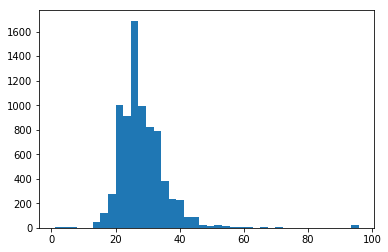

In [104]:
# OBSERVING AGE (without None values)
ages = df.select("age").rdd.flatMap(lambda x: x).collect()
newdf = df.where((col("age") > 0))

ages = newdf.select("age").rdd.flatMap(lambda x: x).collect()
print(len(ages)) # number of users who fill their age
print reduce (lambda x, y: x + y, ages) / len(ages) # average age
plt.hist(ages, bins=40)
plt.show()

In [105]:
#### Вывод №1:
#### Сложно определить настоящий возраст пользователей, так как возраст указан только у 13% пользователей (7817 / 58095)
#### Среди тех, кто указал возраст, средний возраст - 28 лет

In [106]:
# top users by reputation
df.select("UserId", "DisplayName","CreationDate", "Age", "Reputation").orderBy(desc('Reputation')).limit(10).show()

+------+-------------------+------------+----+----------+
|UserId|        DisplayName|CreationDate| Age|Reputation|
+------+-------------------+------------+----+----------+
| 10105|              VladD|  2012-11-02|  16|    110970|
|  2739|            KoVadim|  2011-08-10|null|     61550|
|  5648|           Barmaley|  2012-01-18|   4|     42481|
| 17609|            ЮрийСПб|  2014-02-17|  29|     35622|
|178576|  alexander barakin|  2015-04-08|  46|     35371|
|178988|            Qwertiy|  2015-04-13|  26|     31386|
|   232|                avp|  2011-01-08|  57|     30973|
|     6|Nicolas Chabanovsky|  2010-10-10|  28|     29920|
|  4058|             Deonis|  2011-10-11|  41|     29180|
| 10162|         DreamChild|  2012-11-04|  28|     28885|
+------+-------------------+------------+----+----------+



In [107]:
# top users by views
df.select("UserId", "DisplayName", "CreationDate", "Age", "Views").orderBy(desc('Views')).limit(10).show()

+------+-------------------+------------+----+-----+
|UserId|        DisplayName|CreationDate| Age|Views|
+------+-------------------+------------+----+-----+
| 10105|              VladD|  2012-11-02|  16| 8718|
|     6|Nicolas Chabanovsky|  2010-10-10|  28| 8106|
|  5648|           Barmaley|  2012-01-18|   4| 3491|
|178576|  alexander barakin|  2015-04-08|  46| 3193|
|181472|      Nick Volynkin|  2015-05-15|  30| 2678|
|178779|      Pavel Mayorov|  2015-04-10|null| 2226|
|186999|             Grundy|  2015-08-07|  28| 2149|
|177221|          PashaPash|  2015-04-07|null| 2079|
| 17609|            ЮрийСПб|  2014-02-17|  29| 1993|
|   232|                avp|  2011-01-08|  57| 1952|
+------+-------------------+------------+----+-----+



In [108]:
#### Рейтинги по репутации и кол-ву просмотров похожи: 
#### активные пользователи имеют как большое количество просмотров профиля, так и высокий рейтинг (что, в принципе, логично)

In [109]:
# number of users by location
df.select("UserId", "Location").groupBy("Location").count().orderBy(desc('count')).show()

+--------------------+-----+
|            Location|count|
+--------------------+-----+
|                null|47447|
|              Russia| 1129|
|      Moscow, Russia| 1013|
|             Ukraine|  579|
|St. Petersburg, R...|  265|
|      Minsk, Belarus|  210|
|              Москва|  185|
|              Moscow|  178|
|       Kyiv, Ukraine|  153|
|             Belarus|  149|
|Saint Petersburg,...|  140|
|Москва, город Мос...|  107|
|              Россия|   94|
|     Санкт-Петербург|   78|
|Санкт-Петербург, ...|   77|
| Novosibirsk, Russia|   76|
|       Kiev, Ukraine|   72|
|             Украина|   65|
|Kiev, Kyiv city, ...|   63|
|    Kharkiv, Ukraine|   58|
+--------------------+-----+
only showing top 20 rows



In [110]:
#### Сложно определить географию пользователей, так как локации определены в разных форматах.
#### Например, пользователи из Москвы имеют следующие варианты локаций: 
#### 1) Москва; 
#### 2) Москва, Россия; 
#### 3) Moscow; 
#### 4) Moscow, Russia; 
#### 5) Russia

In [111]:
# df.registerTempTable("users_table")
# sqlContext.sql('select Reputation from users_table').show()

In [119]:
# -*- coding: utf-8 -*-
#  READING XML AND WRITING POSTS DATA TO CSV
from xml.etree import ElementTree
import html
import re, cgi
import HTMLParser
tag_re = re.compile(r'(<!--.*?-->|<[^>]*>)')

tree = ElementTree.parse('Posts.xml')
root = tree.getroot()
header = ('id', 'typeid', 'viewcount','score','UserId', 'tags')
with open('posts.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    
    for ls in root:
        idd = ls.get('Id', '')
        typeid = ls.get('PostTypeId', '')
        viewcount = ls.get('ViewCount', '')
        score = ls.get('Score', '')
        user = ls.get('OwnerUserId', '')
        tags = HTMLParser.HTMLParser().unescape(ls.get('Tags', ''))
        row = idd, typeid, viewcount, score, user, tags
        writer.writerow(row)

In [120]:
# CREATING POSTS SCHEMA
from pyspark.sql.types import StructType, StructField
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType, IntegerType, StringType, DateType
schema2 = StructType([
    StructField("id", IntegerType()),
    StructField("TypeId", IntegerType()),
    StructField("Viewcount", IntegerType()),
    StructField("Score", IntegerType()),
#     StructField("text", StringType())
    StructField("UserId", IntegerType()),
    StructField("Tags", StringType())
])
df2 = sqlContext.read.format('com.databricks.spark.csv') \
.options(header='true').schema(schema2).load('posts.csv')

In [121]:
# SCHEMA
df2.printSchema()

root
 |-- id: integer (nullable = true)
 |-- TypeId: integer (nullable = true)
 |-- Viewcount: integer (nullable = true)
 |-- Score: integer (nullable = true)
 |-- UserId: integer (nullable = true)
 |-- Tags: string (nullable = true)



In [122]:
# SHOWING POSTS
df2.show()

+---+------+---------+-----+------+---------------+
| id|TypeId|Viewcount|Score|UserId|           Tags|
+---+------+---------+-----+------+---------------+
|  1|     1|     6972|   22|     2| <python><smtp>|
|  2|     2|     null|   26|     6|           null|
|  3|     1|     3165|    4|     2|   <postgresql>|
|  4|     2|     null|    4|     6|           null|
|  5|     1|     7403|    5|     2|        <linux>|
|  6|     2|     null|    7|     2|           null|
|  7|     1|     2338|    3|     2|  <svn><прокси>|
|  8|     2|     null|    2|     2|           null|
|  9|     1|     2517|    0|     2|        <linux>|
| 10|     2|     null|    4|     2|           null|
| 11|     1|     2664|    2|     2|        <linux>|
| 12|     2|     null|    6|     6|           null|
| 13|     1|     1903|    3|     2|   <linux><git>|
| 14|     2|     null|    3|     2|           null|
| 15|     1|     1961|    1|     2|           <it>|
| 16|     1|    24009|    3|     2|<linux><ubuntu>|
| 17|     2|

In [123]:
# MERGING POSTS AND USERS
df3 = df2.join(df,['UserId'],"left")

# users and posts they created
df3.orderBy(desc('Viewcount')).show()

+------+------+------+---------+-----+--------------------+----------+------------+-------------------+--------------+---------------+-----+-------+---------+----+---------+
|UserId|    id|TypeId|Viewcount|Score|                Tags|Reputation|CreationDate|        DisplayName|LastAccessDate|       Location|Views|UpVotes|DownVotes| Age|AccountId|
+------+------+------+---------+-----+--------------------+----------+------------+-------------------+--------------+---------------+-----+-------+---------+----+---------+
|     6|   261|     1|   122939|    6|             <linux>|     29920|  2010-10-10|Nicolas Chabanovsky|    2016-12-11|Санкт-Петербург| 8106|  25766|     1608|  28|   272910|
| 10603|304531|     1|   117047|   -1|  <objective-c><ios>|       331|  2012-12-04|      rabbitinspace|    2016-10-30| Moscow, Russia|   17|     37|        1|  22|  5634550|
|  7032|101366|     1|   106722|    3|<windows><cmd><pr...|        16|  2012-04-16|            boiko94|    2012-04-16|           n

In [124]:
# NUMBER OF POSTS CREATED BY USERS
df3.select("UserId", "DisplayName", "Age", "Reputation", "id")\
.groupBy("UserId", "DisplayName", "Age", "Reputation").count().orderBy(desc('count')).limit(10).show()

+------+-------------------+----+----------+-----+
|UserId|        DisplayName| Age|Reputation|count|
+------+-------------------+----+----------+-----+
| 10105|              VladD|  16|    110970| 2669|
|178988|            Qwertiy|  26|     31386| 1620|
|  2739|            KoVadim|null|     61550| 1607|
|178576|  alexander barakin|  46|     35371| 1470|
| 17609|            ЮрийСПб|  29|     35622| 1358|
|  5648|           Barmaley|   4|     42481| 1288|
|     2|          stanislav|  26|     24988| 1279|
|     6|Nicolas Chabanovsky|  28|     29920| 1275|
|   232|                avp|  57|     30973| 1169|
|  7161|            Sergiks|null|     25700| 1085|
+------+-------------------+----+----------+-----+



In [118]:
#### Снова, как и с рейтингами, - 
#### Многие пользователи, попавшие в топ по репутации и кол-ву просмотров, присутствуют и в топе по количеству созданных постов 

In [197]:
# USERS WHO ASK QUESTIONS
df_questions = df3.where(col("TypeId") == 1)
df_questions = df_questions.select("UserId", "DisplayName", "Age", "CreationDate", "Reputation", "LastAccessDate",\
                                   "Location", "Views", "UpVotes", "DownVotes", "id")\
.groupBy("UserId", "DisplayName", "Age", "CreationDate", "Reputation", "LastAccessDate",\
                                   "Location", "Views", "UpVotes", "DownVotes").count().orderBy(desc('count'))\
.selectExpr("UserId", "DisplayName", "Age", "CreationDate", "Reputation", "LastAccessDate",\
                                   "Location", "Views", "UpVotes", "DownVotes", "count as questions")

In [198]:
# USERS WHO ANSWER
df_answers = df3.where(col("TypeId") == 2)
df_answers = df_answers.select("UserId", "id")\
.groupBy("UserId").count().orderBy(desc('count')).selectExpr("UserId", "count as answers")

In [201]:
# MERGING questions and answers
df4 = df_questions.join(df_answers,['UserId'],"left")
df4 = df4.withColumn('diff', df4.questions - df4.answers)
df4.select("UserId", "DisplayName", "Age", "Reputation", "answers", "questions", "diff").\
                                    orderBy(desc('diff')).limit(10).show()

+------+--------------------+----+----------+-------+---------+----+
|UserId|         DisplayName| Age|Reputation|answers|questions|diff|
+------+--------------------+----+----------+-------+---------+----+
|195957|Aleksey Timoshchenko|null|      2814|     44|      416| 372|
|191307|        Rakzin Roman|null|      2364|     73|      387| 314|
| 18030|                Jony|null|       886|     14|      319| 305|
|176382|                Вася|null|      1446|     53|      332| 279|
|  4425|                 Zow|null|      1067|      6|      281| 275|
|  3435|          duddeniska|null|      1364|     26|      293| 267|
|  6646|               ModaL|  21|      2334|     66|      314| 248|
|  4969|            navi1893|null|       803|     17|      253| 236|
|  6953|          eprivalov1|  30|      2457|     78|      311| 233|
|  3537|            Angus123|  19|      1402|     30|      243| 213|
+------+--------------------+----+----------+-------+---------+----+



In [202]:
#### В таблице выше показаны пользователи, которые больше задают вопросов, чем отвечают на вопросы, то есть, те люди,
#### которым чаще требуется помощь

In [203]:
df4_tmp = df4.dropna()
df4_tmp.select("UserId", "DisplayName", "Age", "Reputation", "answers", "questions", "diff").\
                                    orderBy('diff').limit(10).show()

+------+-----------------+----+----------+-------+---------+-----+
|UserId|      DisplayName| Age|Reputation|answers|questions| diff|
+------+-----------------+----+----------+-------+---------+-----+
| 10105|            VladD|  16|    110970|   2650|       11|-2639|
|178576|alexander barakin|  46|     35371|   1431|       21|-1410|
| 17609|          ЮрийСПб|  29|     35622|   1307|       45|-1262|
|  5648|         Barmaley|   4|     42481|   1273|       14|-1259|
|   232|              avp|  57|     30973|   1109|       60|-1049|
|  6117|      Yura Ivanov|  39|     22266|    762|        5| -757|
|  2825|             knes|-972|     23562|    758|       75| -683|
|195342|            Harry|  53|     19024|    682|       20| -662|
|  1252|             ling|  26|     12977|    615|       37| -578|
| 13336|          VenZell|  27|     15513|    567|        2| -565|
+------+-----------------+----+----------+-------+---------+-----+



In [204]:
#### В таблице выше показаны пользователи, которые больше отвечают, чем задают вопросы
#### Как мы видим, в большинстве, это люди, которые имеют высокий рейтинг
#### Таким образом, можно предположить, что эти люди являются экспертами в какой-либо области программирования

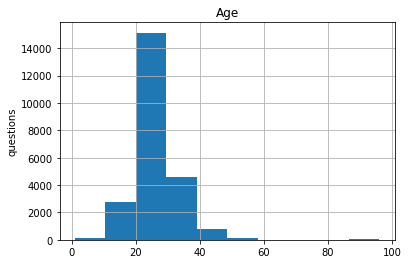

In [205]:
# DISTRIBUTION OF QUESTIONS IN POSTS BY USER AGE
df_questions_tmp = df_questions.dropna()
df_questions_tmp = df_questions_tmp.where((col("Age") > 0))
questions = df_questions_tmp.toPandas()
questions.hist('Age',weights=questions['questions'] )
plt.ylabel('questions')
plt.show()

In [206]:
#### На графике видно, что, в основном, вопросы задают пользователи в возрасте от 20 до 30 лет

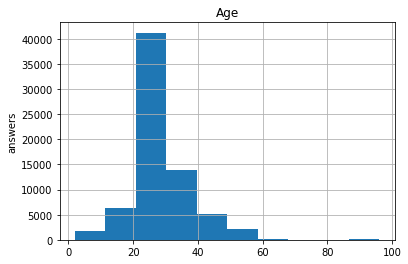

In [207]:
# DISTRIBUTION OF ANSWERS IN POSTS BY USER AGE
df_answers_tmp = df3.where(col("TypeId") == 2)
df_answers_tmp = df_answers_tmp.select("UserId", "Age", "id")\
.groupBy("UserId", "Age").count().orderBy(desc('count')).selectExpr("UserId", "Age", "count as answers")

df_answers_tmp = df_answers_tmp.dropna()
df_answers_tmp = df_answers_tmp.where((col("Age") > 0))
answers = df_answers_tmp.toPandas()
answers.hist('Age',weights=answers['answers'] )
plt.ylabel('answers')
plt.show()

In [208]:
#### Практически схожая картина - в большей степени отвечают пользователи в возрасте от 20 до 30 лет

In [210]:
# SAVING TO CSV FILE (USERS, POSTS AND USERS)
# result1 = df4.toPandas()
result2 = df3.toPandas()
result1.to_csv('users_result.csv', sep=';', index=False, encoding='utf-8')
result2.to_csv('posts_users_result.csv', sep=',', index=False, encoding='utf-8')

In [97]:
sc.stop()